In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics

In [2]:
pyro.set_rng_seed(10)

In [3]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)



(1127, 5237)


In [4]:
class PMF_zero_inflated_poisson(nn.Module):

    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self,data, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.returned = None
        self.predictive_svi = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()
        
        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()
        self.alpha = 1


    def model(self, train, mask):
        alpha = 1
        beta = 1

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #alpha = pyro.sample("alpha", dist.Poisson(self.alpha))
            #relates to drugs that people tend not to report side effects
            p = pyro.sample("p", dist.Beta(alpha, beta))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
           # with pyro.poutine.mask(mask=mask):
             Y = pyro.sample("target", dist.ZeroInflatedPoisson( rate = UA@VA.T ,gate = p[:, np.newaxis]), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
        rate_alpha = pyro.param('rate_alpha', torch.ones(self.n), constraint=constraints.positive)
        rate_beta = pyro.param('rate_beta', torch.ones(self.n), constraint=constraints.positive)


        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
            p = pyro.sample("p", dist.Beta(rate_beta,rate_alpha))

        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,mask, nsteps=500, lr = 0.05, lrd = 1, verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None , unmasked)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        self.predictive_svi = predictive_svi
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)

        self.predictions = mc_table
        
    def predictive_score(self,test,masked):
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        p=self.predictive_svi["p"].mean(axis=0).reshape(self.n)
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        print(UA.shape)
        score =  dist.ZeroInflatedPoisson( rate = UA@VA.T ,gate = p[:, np.newaxis]).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score
        
    
  
    def rmse(self,test,masked,h):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < h] = low
        test_data[test_data >= h] = high
        size = masked.sum()
        predictions = self.predictions
        predictions[predictions < h] = low
        predictions[predictions >= h] = high
        sqerror = abs(test_data[masked] - predictions[masked]) ** 2  # squared error array
        mse = sqerror.sum()/size
        print("PMF  RMSE: " , np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data[masked].astype(int).flatten(),  predictions[masked].astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    def get_predictive_svi(self):
         return (self.predictive_svi)

    
   
       

    

In [5]:
with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

nan_mask = np.isnan(data2) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 


def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(250)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF_zero_inflated_poisson)

(1127, 5237)
UA: (250, 1, 1127, 1)
p: (250, 1, 1127)
VA: (250, 1, 5237, 1)
target: (250, 1127, 5237)
torch.Size([1127, 1])
UA: (250, 1, 1127, 5)
p: (250, 1, 1127)
VA: (250, 1, 5237, 5)
target: (250, 1127, 5237)
torch.Size([1127, 5])
UA: (250, 1, 1127, 10)
p: (250, 1, 1127)
VA: (250, 1, 5237, 10)
target: (250, 1127, 5237)
torch.Size([1127, 10])
UA: (250, 1, 1127, 20)
p: (250, 1, 1127)
VA: (250, 1, 5237, 20)
target: (250, 1127, 5237)
torch.Size([1127, 20])
UA: (250, 1, 1127, 50)
p: (250, 1, 1127)
VA: (250, 1, 5237, 50)
target: (250, 1127, 5237)
torch.Size([1127, 50])
UA: (250, 1, 1127, 75)
p: (250, 1, 1127)
VA: (250, 1, 5237, 75)
target: (250, 1127, 5237)
torch.Size([1127, 75])
UA: (250, 1, 1127, 100)
p: (250, 1, 1127)
VA: (250, 1, 5237, 100)
target: (250, 1127, 5237)
torch.Size([1127, 100])
UA: (250, 1, 1127, 200)
p: (250, 1, 1127)
VA: (250, 1, 5237, 200)
target: (250, 1127, 5237)
torch.Size([1127, 200])
UA: (250, 1, 1127, 250)
p: (250, 1, 1127)
VA: (250, 1, 5237, 250)
target: (250, 112

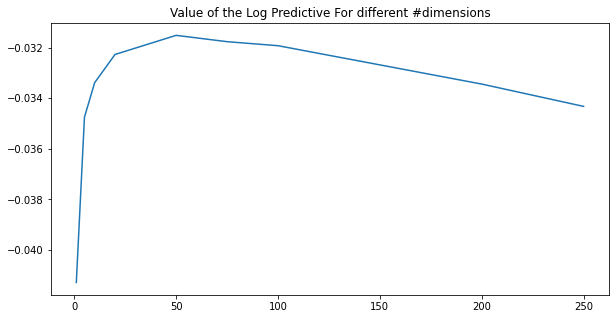

In [6]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
plt.savefig("predictive_score_zip.png")
plt.show()
pyro.clear_param_store()

In [7]:
pyro.clear_param_store()
with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

nan_mask = np.isnan(data2) 
nan_mask = np.isnan(data2) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
test = PMF_zero_inflated_poisson(data,data2,50)
l = test.train_SVI(data, ~torch.from_numpy(nan_mask))



(1127, 5237)
Elbo loss: 221666868.453125
Elbo loss: 59250328.185562134
Elbo loss: 37646607.346191406
Elbo loss: 30770784.318359375
Elbo loss: 28670600.4173584
Elbo loss: 27571284.463928223
Elbo loss: 26003601.450042725
Elbo loss: 23788599.595581055
Elbo loss: 22018007.347808838
Elbo loss: 20487981.767822266
Elbo loss: 19865319.968414307
Elbo loss: 19096413.515777588
Elbo loss: 18682754.693725586
Elbo loss: 18200229.318969727
Elbo loss: 17868067.771209717
Elbo loss: 17812500.239440918
Elbo loss: 17643969.616836548
Elbo loss: 17328857.071166992
Elbo loss: 17117809.5881958
Elbo loss: 16930647.45059204
Elbo loss: 17175470.006835938
Elbo loss: 16922550.02307129
Elbo loss: 16993645.88821411
Elbo loss: 16615313.688903809
Elbo loss: 16645353.967941284
Elbo loss: 16246482.021514893
Elbo loss: 16489908.082214355
Elbo loss: 16365661.2366333
Elbo loss: 16397071.462554932
Elbo loss: 16368568.321868896
Elbo loss: 16331217.35194397
Elbo loss: 16101816.873153687
Elbo loss: 16468280.772460938
Elbo loss

In [13]:
l = test.train_SVI(data, ~torch.from_numpy(nan_mask))

Elbo loss: 15661433.694000244
Elbo loss: 15940501.287765503
Elbo loss: 15783971.491577148
Elbo loss: 15669455.437561035
Elbo loss: 15875942.895736694
Elbo loss: 15674057.493301392
Elbo loss: 15657183.04586792
Elbo loss: 15596108.528396606
Elbo loss: 15435113.207389832
Elbo loss: 15601025.005737305
Elbo loss: 15769058.660995483
Elbo loss: 15490577.7033844
Elbo loss: 15207305.816375732
Elbo loss: 15384983.156326294
Elbo loss: 15708132.477111816
Elbo loss: 15415834.090042114
Elbo loss: 15679070.753387451
Elbo loss: 15403396.94090271
Elbo loss: 15463671.351348877
Elbo loss: 15520119.427062988
Elbo loss: 15557431.86694336
Elbo loss: 15354197.994247437
Elbo loss: 15465424.447860718
Elbo loss: 15598246.803482056
Elbo loss: 15471253.238616943
Elbo loss: 15471011.880371094
Elbo loss: 15332394.122879028
Elbo loss: 15367384.364303589
Elbo loss: 15240450.338897705
Elbo loss: 15615864.015655518
Elbo loss: 15201506.529815674
Elbo loss: 15484390.582244873
Elbo loss: 15447550.930343628
Elbo loss: 1548

In [14]:
test.sample_predict(300)

UA: (300, 1, 1127, 50)
p: (300, 1, 1127)
VA: (300, 1, 5237, 50)
target: (300, 1127, 5237)


In [15]:
nan_mask = np.isnan(data2)
#test rmse
test.rmse(data, nan_mask,1)
#train rmse
test.rmse(data, ~nan_mask,1)

PMF  RMSE:  0.3554934205342255
AUC: 0.81340
PMF  RMSE:  0.3557001192400917
AUC: 0.81339


(0.3557001192400917, 0.8133921402557095)

In [16]:
#test rmse
test.rmse(data, nan_mask,4)
#train rmse
test.rmse(data, ~nan_mask,4)

PMF  RMSE:  0.2935781208202841
AUC: 0.50000
PMF  RMSE:  0.29386885556227027
AUC: 0.50000


(0.29386885556227027, 0.5)

In [17]:
Simple_PMF ={}
Simple_PMF['losses'] = s
Simple_PMF['predictive_score'] = d
Simple_PMF['train_rmse'] = 0.3554
Simple_PMF['test_rmse'] = 0.3557
Simple_PMF['AUC'] = 0.8340
Simple_PMF['train_rmse_3'] = 0.2935
Simple_PMF['test_rmse_3'] = 0.2938
Simple_PMF['predictions'] = test.get_predictions()
with open('SVI_zero_inflated_poisson', 'wb') as handle:
    pickle.dump(Simple_PMF, handle, protocol=pickle.HIGHEST_PROTOCOL)
